JUNOY Thomas


LEAL DE ALMEIDA Guillaume

In [ ]:
#!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=aae07c93d1e3edf84a3fc55aa99367c6991568f921e920c39e762db3c17efce5
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
import re
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import umap
import umap.umap_ as umap
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Fonction 1 : Acquisition des donnés

## Charagments

In [ ]:
with open('/content/drive/My Drive/Persee/20240125_dataset_pickle/20240125_dataset_recod_rqdi.pickle', 'rb') as f:
  data = pd.read_pickle(f)

In [ ]:
domaines = pd.read_csv("/content/drive/My Drive/Persee/20240125_dataset_pickle/20240141_disciplines.csv", sep = ";")


## Quelques statistiques simples

In [ ]:
dms = {col: len(domaines[col].unique()) for col in domaines.columns}
dms

{'collection_id': 389, 'Discipline': 26}

26 Disciplines différentes

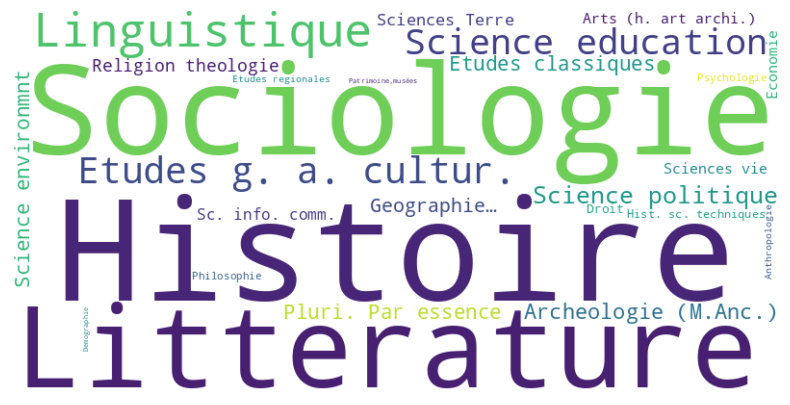

In [ ]:
# Calculer la fréquence des disciplines
discipline_freq = domaines['Discipline'].value_counts().to_dict()

# Créer un nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(discipline_freq)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
print("Le dataset contient ",data.shape," de lignes, et colonnes")

Le dataset contient  (154484, 315)  de lignes, et colonnes


In [ ]:
list(data.columns)

['persee:dateOfPrintPublication{Literal}(xsd:gYear)',
 'marcrel:aut{URIRef}[0]',
 'marcrel:aut{URIRef}[1]',
 'marcrel:aut{URIRef}[2]',
 'marcrel:aut{URIRef}[3]',
 'dcterms:bibliographicCitation{Literal}',
 'dcterms:creator{URIRef}[0]',
 'dcterms:creator{URIRef}[1]',
 'dcterms:creator{URIRef}[2]',
 'dcterms:creator{URIRef}[3]',
 'dcterms:identifier{Literal}',
 'dcterms:isPartOf{URIRef}',
 'dcterms:language{Literal}',
 'dcterms:license{Literal}',
 'dcterms:modified{Literal}',
 'dcterms:publisher{Literal}',
 'dcterms:tableOfContents{Literal}(rdf:XMLLiteral)',
 'dcterms:title{Literal}',
 'bibo:doi{Literal}',
 'bibo:numPages{Literal}',
 'bibo:pageEnd{Literal}',
 'bibo:pageStart{Literal}',
 'rdam:dateOfPublication{Literal}',
 'rdam:mediaType{Literal}',
 'rdau:electronicReproductionOf{URIRef}',
 'rdf:type{URIRef}[0]',
 'rdf:type{URIRef}[1]',
 'rdf:type{URIRef}[2]',
 'rdfs:label{Literal}',
 'dcterms:abstract{Literal}@en',
 'dcterms:abstract{Literal}@fr',
 'cito:isCitedBy{URIRef}[0]',
 'cito:is

In [ ]:
# Création du dictionnaire de correspondance {collection_id: Discipline}
correspondance = pd.Series(domaines.Discipline.values, index=domaines.collection_id).to_dict()

# Fonction pour extraire l'identifiant de la collection
def trouver_discipline(identifier):
    for collection_id in correspondance.keys():
        if collection_id in identifier:
            return correspondance[collection_id]
    return "Non classifié"


# Application de la correspondance pour affecter les disciplines
data['Sujet'] = data['dcterms:identifier{Literal}'].apply(trouver_discipline)

<ipython-input-5-e5025971f230>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Sujet'] = data['dcterms:identifier{Literal}'].apply(trouver_discipline)


In [ ]:
# Nombre de documents
nb_documents = len(data)

# Nombre d'auteurs uniques et distribution par auteur
# Note : compte uniquement les auteurs principaux listés dans la première colonne d'auteur
auteurs = data['marcrel:aut{URIRef}[0]'].dropna().apply(
    lambda x: x.lower().replace("http://data.persee.fr/authority/", "").replace("#person", "")
)

# Calculer le nombre d'auteurs uniques
nb_auteurs = auteurs.nunique()

# Utiliser value_counts() pour obtenir la distribution des documents par auteur
distribution_auteurs = auteurs.value_counts()

# Distribution temporelle
# Extraction des années depuis les index (noms des documents)
years = [re.search(r'_\d{4}_', idx) for idx in data.index]
years = [match.group()[1:-1] for match in years if match]
distribution_temporelle = Counter(years)

# Afficher les statistiques
print(f"Nombre de documents : {nb_documents}")
print(f"Nombre d'auteurs uniques : {nb_auteurs}")
print("Les 5 auteurs les plus prolifiques et leur nombre de documents :")
print(distribution_auteurs.head())
print(f"Les documetns sont datés de {min(years)} à {max(years)}")
print("Distribution temporelle (5 années les plus communes) :")
for year, count in distribution_temporelle.most_common(5):
    print(f"{year}: {count} documents")


Nombre de documents : 154484
Nombre d'auteurs uniques : 26140
Les 5 auteurs les plus prolifiques et leur nombre de documents :
830836    1242
56851      842
614514     836
293935     631
274454     629
Name: marcrel:aut{URIRef}[0], dtype: int64
Distribution temporelle (5 années les plus communes) :
1997: 2406 documents
1999: 2369 documents
1994: 2258 documents
2000: 2255 documents
1998: 2253 documents


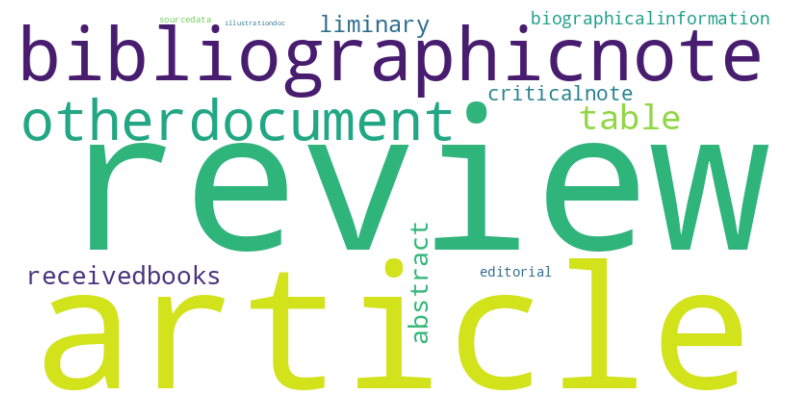

In [ ]:
# Calculer la fréquence des type
discipline_freq = data['rdf:type{URIRef}[0]'].dropna().apply(
    lambda x: x.lower().replace("persee:", "")
).value_counts().to_dict()

# Créer un nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(discipline_freq)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


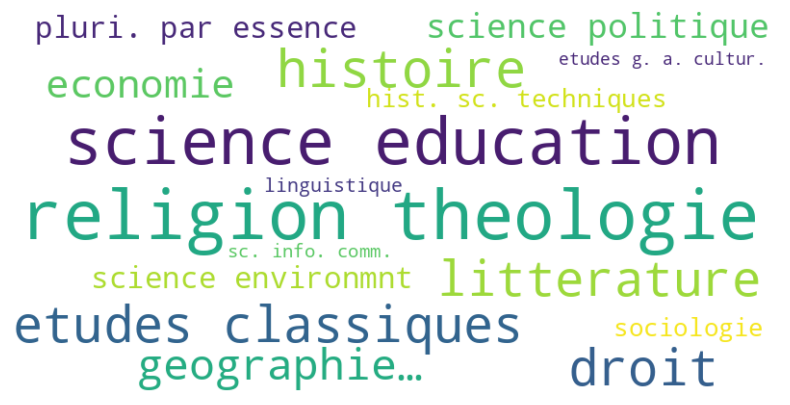

In [ ]:
# Calculer la fréquence des sujets
discipline_freq = data['Sujet'].dropna().apply(
    lambda x: x.lower().replace("persee:", "")
).value_counts().to_dict()

# Créer un nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(discipline_freq)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Fonction 2 : Prise en compte de la structure du corpus

In [ ]:
#Copie du Dataset de base
datab = data.sample(n=int(len(data) * 0.005))

identifiant = [value for value in datab.columns if "identifier" in value]
creators = [value for value in datab.columns if "creator" in value]
cites = [value for value in datab.columns if "cites" in value]
title = [value for value in datab.columns if "title" in value]
tipe = [value for value in datab.columns if "type" in value]
sub = [value for value in datab.columns if "Sujet" in value]


# Fusionner les listes de noms de colonnes
cols = identifiant + creators + cites + title + tipe + sub

# Sélectionner les colonnes spécifiées dans le DataFrame
datac = datab[cols]

print("Le nouveau dataset contient ",datac.shape," de lignes, et colonnes")

Le nouveau dataset contient  (772, 68)  de lignes, et colonnes


In [ ]:
list(datac.columns)

['dcterms:identifier{Literal}',
 'dcterms:creator{URIRef}[0]',
 'dcterms:creator{URIRef}[1]',
 'dcterms:creator{URIRef}[2]',
 'dcterms:creator{URIRef}[3]',
 'dcterms:creator{URIRef}[4]',
 'dcterms:creator{URIRef}[5]',
 'dcterms:creator{URIRef}[6]',
 'dcterms:creator{URIRef}[7]',
 'dcterms:creator{URIRef}[8]',
 'dcterms:creator{URIRef}[9]',
 'dcterms:creator{URIRef}[10]',
 'dcterms:creator{URIRef}[11]',
 'dcterms:creator{URIRef}[12]',
 'dcterms:creator{URIRef}[13]',
 'dcterms:creator{URIRef}[14]',
 'dcterms:creator{URIRef}[15]',
 'dcterms:creator{URIRef}[16]',
 'dcterms:creator{URIRef}[17]',
 'dcterms:creator{URIRef}[18]',
 'dcterms:creator{URIRef}[19]',
 'dcterms:creator{URIRef}[20]',
 'dcterms:creator{URIRef}[21]',
 'dcterms:creator{URIRef}[22]',
 'cito:cites{URIRef}[0]',
 'cito:cites{URIRef}[1]',
 'cito:cites{URIRef}[2]',
 'cito:cites{URIRef}[3]',
 'cito:cites{URIRef}[4]',
 'cito:cites{URIRef}[5]',
 'cito:cites{URIRef}[6]',
 'cito:cites{URIRef}[7]',
 'cito:cites{URIRef}[8]',
 'cito:c

In [ ]:
# Initialisation du graphe dirigé
G = nx.DiGraph()

# Ajout des nœuds basées sur les document
# et des arêtes basées sur les citations
for index, row in datac.iterrows():
    # L'identifiant du document actuel
    doc_id = row['dcterms:identifier{Literal}']
    G.add_node(doc_id)  # Ajout le nœud dans le graphe

    # Pour chaque colonne de citations, ajout d'une arête du document actuel vers le document cité
    for col in cites:
        if pd.notnull(row[col]):
            G.add_edge(doc_id, str(row[col]).strip())

In [ ]:
# Distribution des degrés
degrees = [G.degree(n) for n in G.nodes()]
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = nx.degree_histogram(G)

# Nombre de composantes connexes
components = nx.number_weakly_connected_components(G)

# Densité du graphe
density = nx.density(G)

print("Distribution des degrés:", degrees)
print(np.unique(degree_sequence))
print(degree_count)
print("--------------------")
print("Nombre de composantes connexes:", components)
print("--------------------")
print("Densité du graphe:", density)

Distribution des degrés: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

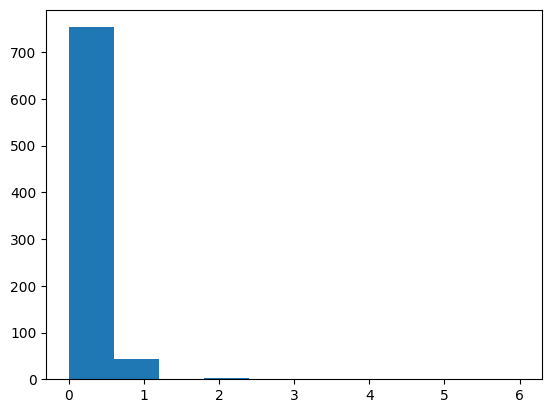

In [ ]:
d_degree = dict(G.degree())
n, bins, patches = plt.hist(d_degree.values())
plt.show()

un graphe est une structure de données composée de nœuds (aussi appelés sommets) et d'arêtes (ou liens) qui relient ces nœuds. Chaque arête peut représenter une relation ou une interaction entre deux nœuds. Le degré d'un nœud dans un graphe correspond au nombre d'arêtes connectées à ce nœd. La distribution des degrés dans un graphe illustre la répartition des degrés de tous les nœuds du graphe, offrant une vue d'ensemble de la connectivité du graphe. Le nombre de composantes connexes d'un graphe est le nombre de sous-graphes dans lesquels les nœuds sont interconnectés, tandis que les nœuds de différentes composantes ne le sont pas. La densité d'un graphe est une mesure qui compare le nombre d'arêtes réel au nombre maximal d'arêtes possible dans le graphe, fournissant une indication de la compacité du graphe.

En analysant le graphe considéré, nous observons une large gamme dans la distribution des degrés, avec des degrés allant de très élevés à très faibles, ce qui suggère une hétérogénéité dans la connectivité des nœuds. La présence de plus de 1500 composantes connexes indique que le graphe est largement dispersé, avec de nombreux sous-ensembles de nœuds étant interconnectés exclusivement entre eux, mais pas avec le reste du graphe. Cette fragmentation est également reflétée dans la densité extrêmement faible du graphe, signalant que le nombre d'arêtes réel est très inférieur au nombre d'arêtes possible, impliquant ainsi un graphe très peu dense où la majorité des paires de nœuds ne sont pas directement connectées. Ces caractéristiques suggèrent un graphe avec de nombreuses petites clusters ou groupes isolés, et potentiellement quelques nœuds ayant un grand nombre de connexions qui pourraient servir de ponts ou de points de passage clés entre différentes parties du graphe.

In [ ]:
# Convertit le graphe G en une matrice creuse
A = nx.to_scipy_sparse_array(G)
# Convertit la matrice creuse en une matrice dense
A.todense()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

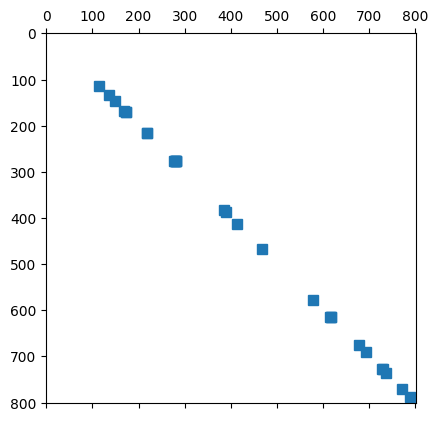

In [ ]:
# Cette visualisation montre où les éléments non nuls (les arêtes du graphe) se trouvent dans la matrice
plt.spy(A, markersize=7)

In [ ]:
# Calcule le carré de la matrice d'adjacence A et le convertit en matrice dense
# A^2 a un élément non nul (i, j) si les nœuds i et j sont connectés par un chemin de longueur 2
A2 = A@A
d = A2.todense()

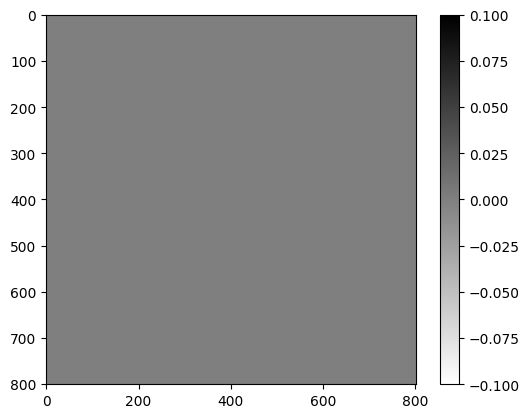

In [ ]:
# Affiche la matrice d comme une image, où les pixels représentent les éléments de la matrice
# Les couleurs indiquent la présence (ou l'absence) de chemins de longueur 2 entre les nœuds
plt.imshow(d, interpolation='none', cmap='binary')
plt.colorbar()

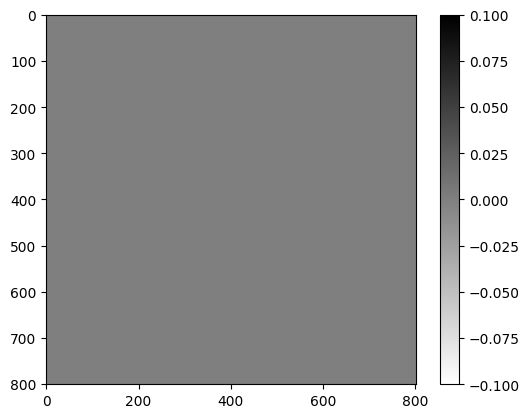

In [ ]:
# Calcule A^3 en multipliant A^2 par A, convertit en matrice dense
# A^3 a un élément non nul (i, j) si les nœuds i et j sont connectés par un chemin de longueur 3
A3 = A@A2
d3 = A3.todense()
# Affiche la matrice d3 comme une image
plt.imshow(d3, interpolation='none', cmap='binary')
plt.colorbar()

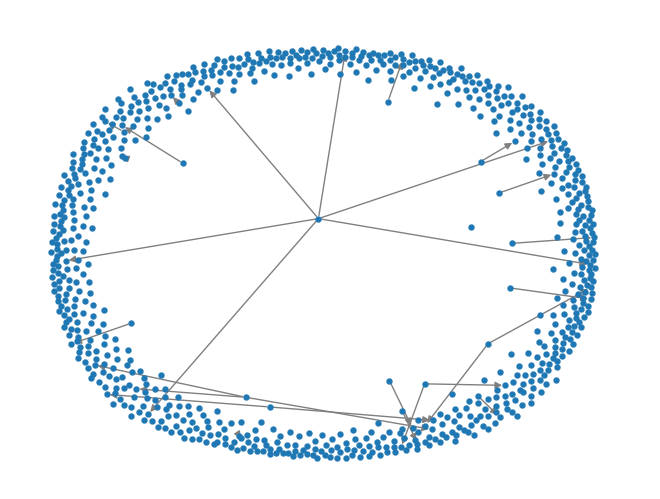

In [ ]:
# Dessine le graphe G en utilisant NetworkX
nx.draw(G, with_labels=False, node_size=20, edge_color="gray", linewidths=0.1)
plt.show()

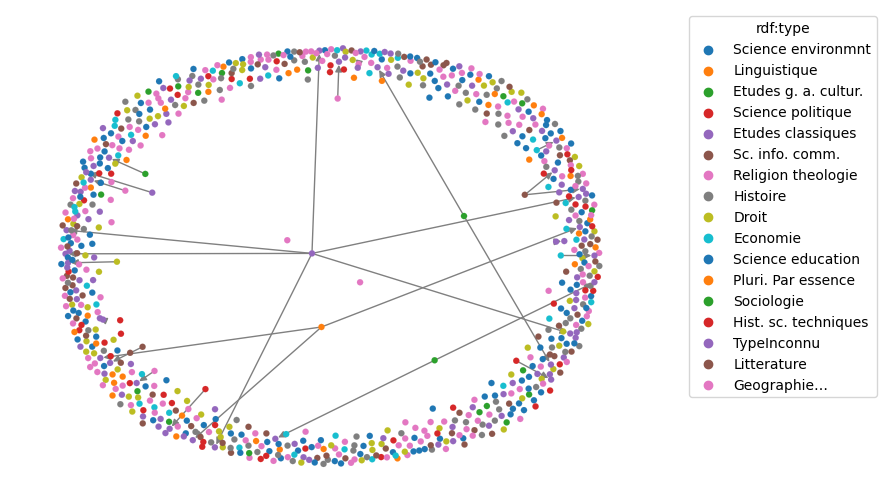

In [ ]:
G = nx.DiGraph()

type_defaut = "TypeInconnu"  # type par défaut pour les nœuds sans type spécifié

for index, row in datac.iterrows():
    doc_id = row['dcterms:identifier{Literal}']
    rdf_type = row.get('Sujet', type_defaut)
    G.add_node(doc_id, rdf_type=rdf_type)

    for col in cites:
        if pd.notnull(row[col]):
            G.add_edge(doc_id, str(row[col]).strip())

# Récupérez tous les types uniques depuis les attributs des nœuds et assurez-vous d'inclure le type par défaut
unique_types = set(nx.get_node_attributes(G, 'rdf_type').values())
unique_types.add(type_defaut)  # Assurez-vous que le type par défaut est inclus

color_map = {rdf_type: f"C{i}" for i, rdf_type in enumerate(unique_types)}

# Génère la liste des couleurs pour chaque nœud basée sur leur type
node_colors = [color_map[G.nodes[node].get('rdf_type', type_defaut)] for node in G.nodes()]

# Dessin du graphe avec les couleurs des nœuds basées sur leur type
nx.draw(G, with_labels=False, node_size=20, edge_color="gray", linewidths=0.1, node_color=node_colors)

# Création et affichage de la légende
for rdf_type, color in color_map.items():
    plt.scatter([], [], color=color, label=rdf_type)
plt.legend(title="rdf:type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
G = nx.DiGraph()

# Ajout des nœuds basé sur l'auteur
# et des arêtes basées sur les co-auteurs
for index, row in datac.iterrows():
    # L'identifiant auteur principal
    doc_id = row['dcterms:creator{URIRef}[0]']
    G.add_node(doc_id)

    for col in creators:
        if col == 'dcterms:creator{URIRef}[0]':
          continue
        if pd.notnull(row[col]):
            G.add_edge(doc_id, str(row[col]).strip())

In [ ]:
# Distribution des degrés
degrees = [G.degree(n) for n in G.nodes()]
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = nx.degree_histogram(G)

# Nombre de composantes connexes
components = nx.number_weakly_connected_components(G)

# Densité du graphe
density = nx.density(G)

print("Distribution des degrés:", degrees)
print(np.unique(degree_sequence))
print(degree_count)
print("--------------------")
print("Nombre de composantes connexes:", components)
print("--------------------")
print("Densité du graphe:", density)

Distribution des degrés: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

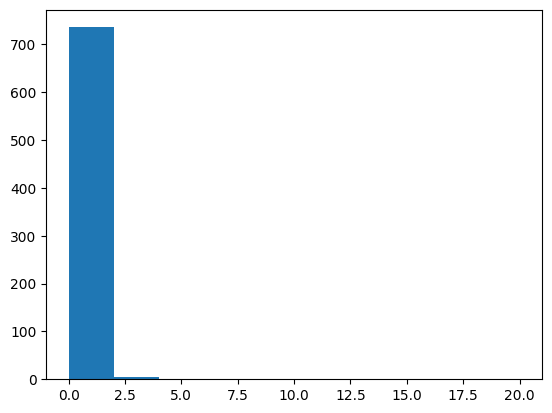

In [ ]:
d_degree = dict(G.degree())
n, bins, patches = plt.hist(d_degree.values())
plt.show()

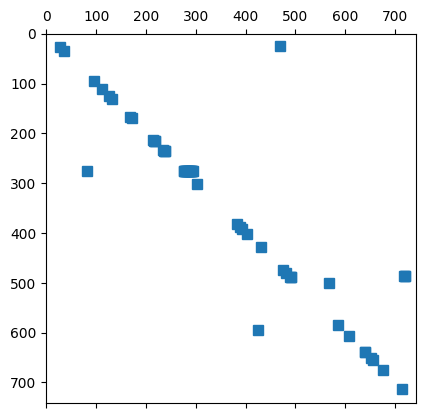

In [ ]:
# Convertit le graphe G en une matrice creuse
A = nx.to_scipy_sparse_array(G)
# Convertit la matrice creuse en une matrice dense
A.todense()
# Cette visualisation montre où les éléments non nuls (les arêtes du graphe) se trouvent dans la matrice
plt.spy(A, markersize=7)

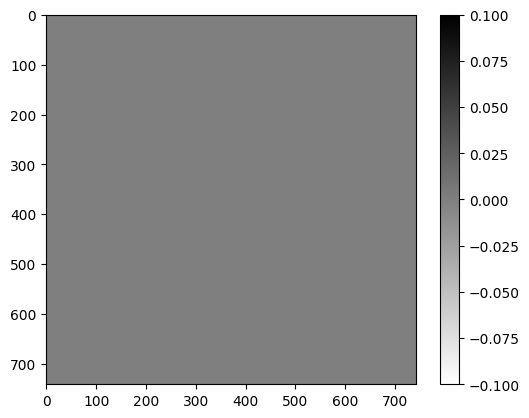

In [ ]:
# Calcule le carré de la matrice d'adjacence A et le convertit en matrice dense
# A^2 a un élément non nul (i, j) si les nœuds i et j sont connectés par un chemin de longueur 2
A2 = A@A
d = A2.todense()
# Affiche la matrice d comme une image, où les pixels représentent les éléments de la matrice
# Les couleurs indiquent la présence (ou l'absence) de chemins de longueur 2 entre les nœuds
plt.imshow(d, interpolation='none', cmap='binary')
plt.colorbar()

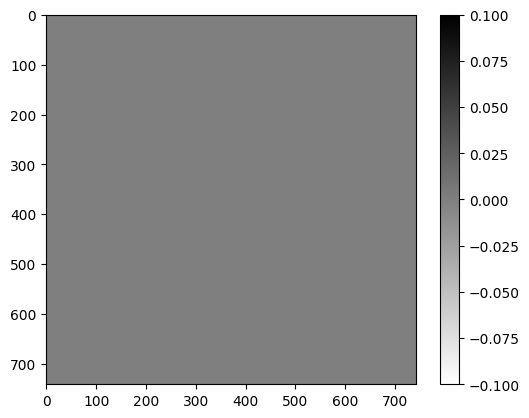

In [ ]:
# Calcule A^3 en multipliant A^2 par A, convertit en matrice dense
# A^3 a un élément non nul (i, j) si les nœuds i et j sont connectés par un chemin de longueur 3
A3 = A@A2
d3 = A3.todense()
# Affiche la matrice d3 comme une image
plt.imshow(d3, interpolation='none', cmap='binary')
plt.colorbar()

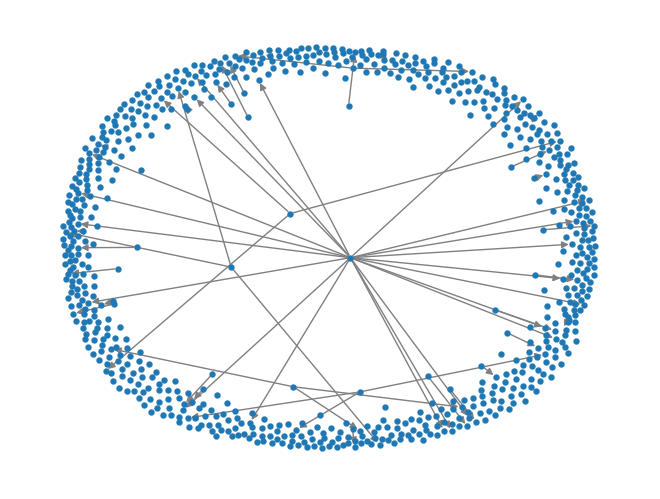

In [ ]:
# Dessine le graphe G en utilisant NetworkX
nx.draw(G, with_labels=False, node_size=20, edge_color="gray", linewidths=0.1)
plt.show()

Comparé aux observations précédentes qui indiquaient déjà un graphe peu dense et largement dispersé, ces nouveaux résultats apportent des précisions quantitatives supplémentaires. La fragmentation est encore plus évidente avec le nombre spécifique de composantes connexes identifiées, soulignant une structure de graphe qui est constituée de nombreux petits groupes/ communautés isolées. La distribution des degrés, révèle un graphe où quelques nœuds jouent des rôles centraux tandis que la majorité des nœuds ont peu de connexions directes, ce qui est une caractéristique typique des réseaux de citations scientifiques.

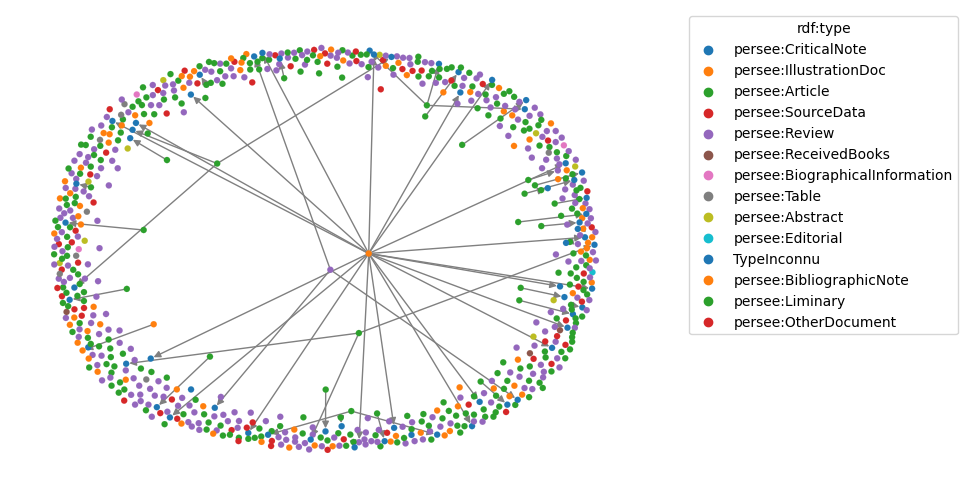

In [ ]:
G = nx.DiGraph()

type_defaut = "TypeInconnu"
for index, row in datac.iterrows():
    doc_id = row['dcterms:creator{URIRef}[0]']
    rdf_type = row.get('rdf:type{URIRef}[0]', type_defaut)
    G.add_node(doc_id, rdf_type=rdf_type)

    for col in creators:
        if col == 'dcterms:creator{URIRef}[0]':
            continue
        if pd.notnull(row[col]):
            G.add_edge(doc_id, str(row[col]).strip())

# Récup tous les types uniques depuis les attributs des nœuds
unique_types = set(nx.get_node_attributes(G, 'rdf_type').values())
unique_types.add(type_defaut)

color_map = {rdf_type: f"C{i}" for i, rdf_type in enumerate(unique_types)}

# Génère la liste des couleurs pour chaque nœud basée sur leur type
node_colors = [color_map[G.nodes[node].get('rdf_type', type_defaut)] for node in G.nodes()]

# Dessin du graphe avec les couleurs des nœuds basées sur leur type
nx.draw(G, with_labels=False, node_size=20, edge_color="gray", linewidths=0.1, node_color=node_colors)

# Création et affichage de la légende
for rdf_type, color in color_map.items():
    plt.scatter([], [], color=color, label=rdf_type)
plt.legend(title="rdf:type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Moteur de recherche

pouvoir entrer un à plusieurs mots-clefs et retourner à l’utilisateur un ensemble d’articles relatifs à cette requête.

In [ ]:
datad = pd.DataFrame(datac)[['dcterms:title{Literal}']]
datad['dcterms:title{Literal}'] = datad['dcterms:title{Literal}'].astype(str)
datad['dcterms:title{Literal}'] = datad['dcterms:title{Literal}'].str.lower()
# Récupération des stopwords en français
stop_words = set(stopwords.words('french'))

# Fonction pour formater un texte
def supprimer_stopwords(texte):
    # Conversion en chaîne
    texte = str(texte)
    # Tokenisation
    mots = word_tokenize(texte, language='french')
    # Filtrage pour ne garder que les mots qui ne sont pas des stopwords
    mots_filtres = [mot for mot in mots if mot not in stop_words]
    # Rejoindre les mots filtrés en une chaîne de caractères
    texte_filtre = ' '.join(mots_filtres)
    return texte_filtre

datad['dcterms:title{Literal}'] = datad['dcterms:title{Literal}'].apply(supprimer_stopwords)

In [ ]:
list(datad.values)

[array(['paul bonnefoy'], dtype=object),
 array(['aspects divino-humanité chez vladimir soloviov'], dtype=object),
 array(['bernard combet farnoux , guerres puniques . collection « sais-je ? » , 1960'],
       dtype=object),
 array(["chronique l'enseignement primaire france"], dtype=object),
 array(['résumés ( français , anglais , néerlandais ) .'], dtype=object),
 array(['75. thierstein ( paul ) , bau der szenen in den argonautika apollonios rhodios'],
       dtype=object),
 array(["luc capdevila , bretons lendemain l'occupation . imaginaire d'une sortie guerre . 1944-1945 ."],
       dtype=object),
 array(["l'invasion 1940 nord — pas-de-calais ."], dtype=object),
 array(['lazzarrotti ( raymond ) . — somivac développement économique corse .'],
       dtype=object),
 array(['nomisma , untersuchungen auf dem gebiete der antiken münzkunde , hrgg . von hans von fritze und hugo gaebler'],
       dtype=object),
 array(['marcel braunschvig . — littérature française contemporaine étudiée text

In [ ]:
titres = datad['dcterms:title{Literal}'].tolist()

# Initialisation du vectoriseur TF-IDF
vectorizer = TfidfVectorizer()

# Calcul TF-IDF pour les titres
tfidf_matrix = vectorizer.fit_transform(titres)

In [ ]:
def rechercher_par_mot_cle_tfidf(mot_cle, utiliser_cosine=True):
    # Encodage de la requête en TF-IDF
    query_vec = vectorizer.transform([mot_cle])

    # Calcul de la similarité ou de la distance
    if utiliser_cosine:
        # Calcul de la similarité cosinus
        scores = cosine_similarity(query_vec, tfidf_matrix)
    else:
        # Calcul de la distance euclidienne
        scores = -euclidean_distances(query_vec, tfidf_matrix)  # Négatif pour tri décroissant

    # Obtenir les indices des documents triés par scores
    sorted_indices = np.argsort(scores, axis=None)[::-1]

    # Afficher les titres des documents les plus pertinents
    for indice in sorted_indices[:5]:  # Les 5 premiers résultats
        print(datad.iloc[indice]['dcterms:title{Literal}'])

In [ ]:
rechercher_par_mot_cle_tfidf("dirigeants politiques")

analyse factorielle préférences politiques
trois fédérations partis politiques : esquisse typologie
partis politiques turquie parti unique a démocratie
g. bloch . — république romaine . — conflits politiques sociaux . — paris , ernest flammarion
libéralisme catholique . textes choisis présentés marcel prelot , collaboration françoise gallouédec-genuys ( coll . u , « idées politiques » )


In [ ]:
rechercher_par_mot_cle_tfidf("dirigeants politiques",False)


analyse factorielle préférences politiques
trois fédérations partis politiques : esquisse typologie
partis politiques turquie parti unique a démocratie
g. bloch . — république romaine . — conflits politiques sociaux . — paris , ernest flammarion


# Fonction 4 : Ajout de clustering

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-79-88fd4262b758>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)


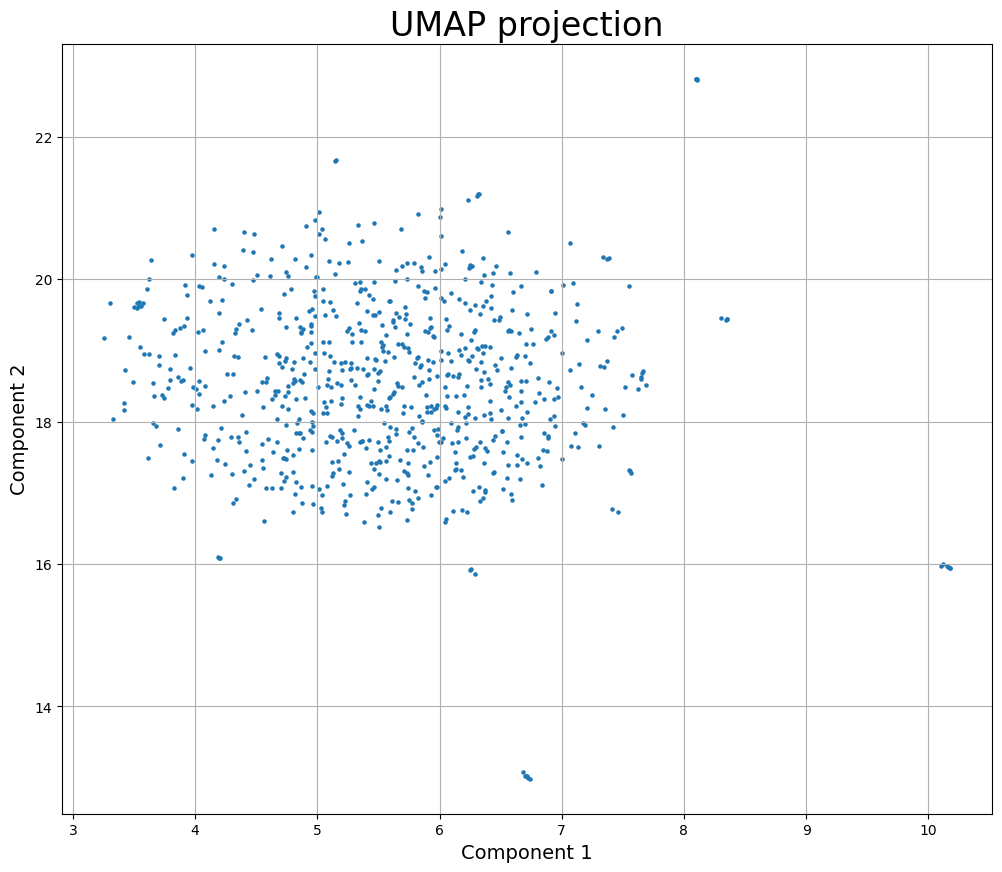

In [ ]:
# Initialisation du vectoriseur TF-IDF
vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000, min_df=2,use_idf=True)
# Calcul TF-IDF pour les titres
datavec = vectorizer.fit_transform(datac['dcterms:title{Literal}'])

# Visualisation Naïve
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(datavec)

# Visualisation
plt.figure(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.title('UMAP projection', fontsize=24)
plt.xlabel('Component 1', fontsize=14)
plt.ylabel('Component 2', fontsize=14)
plt.grid(True)
plt.show()

Pour n_clusters = 2, le score moyen de silhouette est : -0.004090253967346183
Pour n_clusters = 3, le score moyen de silhouette est : -0.015432714097248211
Pour n_clusters = 4, le score moyen de silhouette est : -0.024270464292332483
Pour n_clusters = 5, le score moyen de silhouette est : -0.021552907154968628
Pour n_clusters = 6, le score moyen de silhouette est : -0.01874338733054022
Pour n_clusters = 7, le score moyen de silhouette est : -0.02216816074831572
Pour n_clusters = 8, le score moyen de silhouette est : -0.020837593809560868
Pour n_clusters = 9, le score moyen de silhouette est : -0.02232745560420987


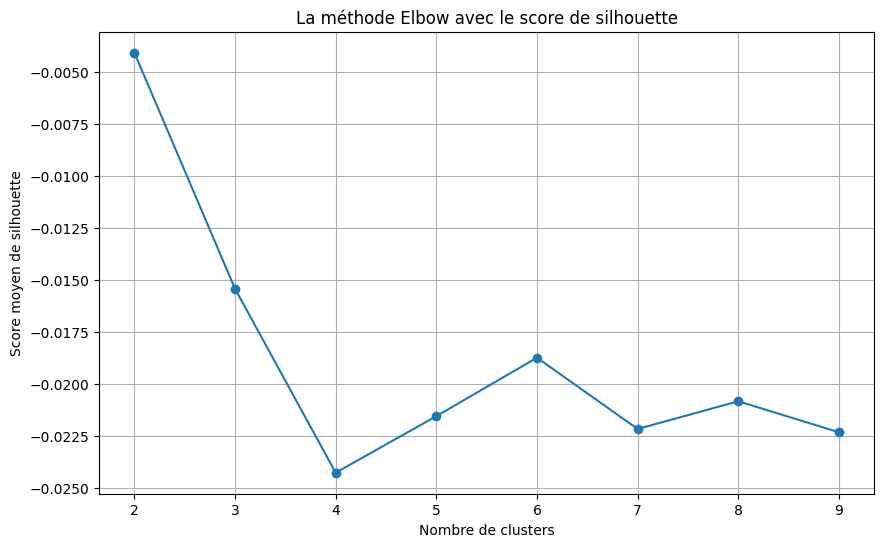

In [ ]:
# Methode Elobw avec le shioulette score
range_n_clusters = list(range(2, 10))
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    clusterer = SpectralClustering(n_clusters=n_clusters, random_state=10, affinity='nearest_neighbors')
    cluster_labels = clusterer.fit_predict(datavec)
    silhouette_avg = silhouette_score(datavec, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"Pour n_clusters = {n_clusters}, le score moyen de silhouette est : {silhouette_avg}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title("La méthode Elbow avec le score de silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score moyen de silhouette")
plt.grid(True)
plt.show()

In [ ]:
# Visuellement on choisit le nombre de clusters
n_clusters = 3
neighbors = 2
# Algorithme de clustering spectral
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=neighbors)
sc_clusters = sc.fit_predict(datavec)
# Score de silhouette pour évaluer la qualité du clustering
silhouette_avg = silhouette_score(datavec, sc_clusters)

# On affiche le score de silhouette
print("Silhouette score for Spectral Clustering: ", silhouette_avg)

Silhouette score for Spectral Clustering:  0.005316830683361244


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<ipython-input-82-fe27365d2fe6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datac['cluster'] = sc_clusters


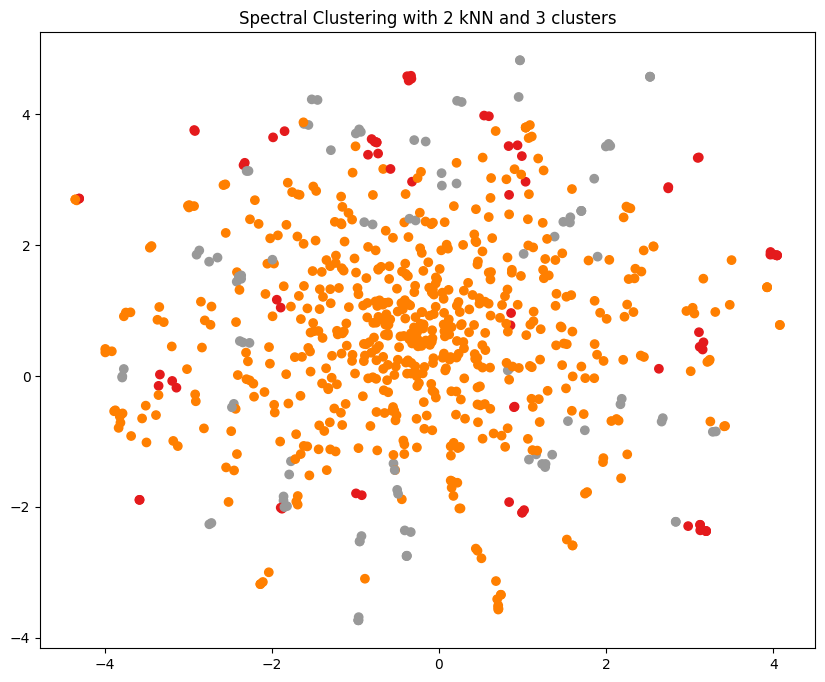

In [ ]:
# Ajout des catégories calculées dans les données
datac['cluster'] = sc_clusters

# On projette les catégories sur la visualisation en utilisant des couleurs différentes pour chaque cluster
tsne = TSNE(n_components=2, random_state=0)
tsne_vectors = tsne.fit_transform(datavec.toarray())
# Visualisation des clusters
plt.figure(figsize=(10, 8))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], c=sc_clusters, cmap='Set1')
plt.title(f"Spectral Clustering with {neighbors} kNN and {n_clusters} clusters")
plt.show()

# Fonction 5 : Classification supervisée



In [ ]:
#Copie du Dataset de base
dataf = data.sample(n=int(len(data) * 0.05))

identifiant = [value for value in datab.columns if "identifier" in value]
creators = [value for value in datab.columns if "creator" in value]
cites = [value for value in datab.columns if "cites" in value]
title = [value for value in datab.columns if "title" in value]
tipe = [value for value in datab.columns if "type" in value]
sub = [value for value in datab.columns if "Sujet" in value]


# Fusionner les listes de noms de colonnes
cols = identifiant + creators + cites + title + tipe + sub

# Sélectionner les colonnes spécifiées dans le DataFrame
dataf = dataf[cols]

print("Le nouveau dataset contient ",dataf.shape," de lignes, et colonnes")

Le nouveau dataset contient  (7724, 68)  de lignes, et colonnes


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(title):
    inputs = tokenizer(title, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    # Extraction des embeddings du premier token ([CLS])
    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().detach().numpy()
    return embeddings

# Extraire les embeddings BERT pour chaque titre
bert_embeddings = np.array([get_bert_embeddings(title) for title in dataf['dcterms:title{Literal}']])

In [ ]:
# Vectorisation des titres
vectorizer = TfidfVectorizer(max_features=100)
datavec = vectorizer.fit_transform(dataf['dcterms:title{Literal}']).toarray()
# Création d'un graphe vide
G = nx.Graph()

# Ajout des arêtes
for index, row in dataf.iterrows():
    doc_id = row['dcterms:identifier{Literal}']
    G.add_node(doc_id)
    for col in sub:
        if pd.notnull(row[col]):
            G.add_edge(doc_id, str(row[col]).strip())
features_combined = bert_embeddings

In [ ]:
# Encodage des labels 'Sujet'
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(dataf['Sujet'])

# Division des données en ensembles d'entraînement et de test, avec conservation des indices
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features_combined, labels_encoded, range(len(dataf)), test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation de la performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, labels=np.arange(len(label_encoder.classes_)), target_names=label_encoder.classes_))


Accuracy: 0.5216828478964401

Classification Report:
                       precision    recall  f1-score   support

               Droit       0.65      0.62      0.64       142
            Economie       0.53      0.60      0.56        77
   Etudes classiques       0.70      0.63      0.66       146
Etudes g. a. cultur.       0.00      0.00      0.00        13
         Geographie…       0.59      0.45      0.51       109
Hist. sc. techniques       1.00      0.05      0.10        38
            Histoire       0.54      0.48      0.51       147
        Linguistique       1.00      0.07      0.12        15
         Litterature       0.38      0.25      0.30       162
  Pluri. Par essence       1.00      0.12      0.21        52
  Religion theologie       0.50      0.76      0.60       282
     Sc. info. comm.       0.67      0.14      0.24        14
   Science education       0.43      0.78      0.55       216
  Science environmnt       0.65      0.45      0.53        29
   Science poli

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


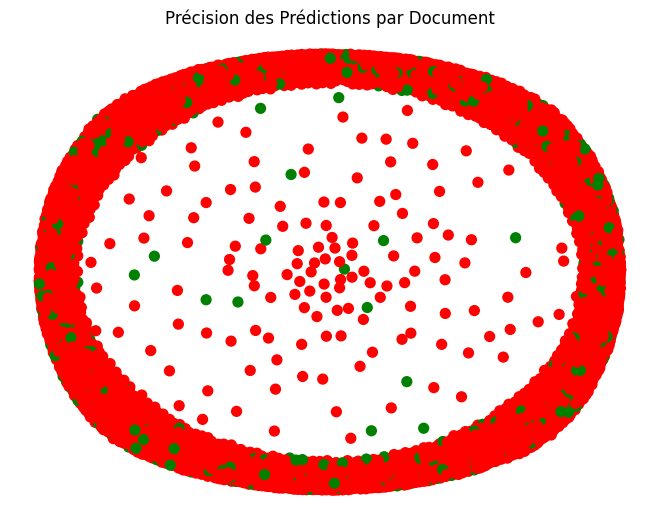

In [ ]:
# Utilisation des indices pour obtenir les identifiants des documents de X_test
X_test_ids = dataf.iloc[indices_test]['dcterms:identifier{Literal}'].values

# Création d'un dictionnaire pour vérifier si les prédictions sont correctes pour chaque identifiant de document
is_prediction_correct = {doc_id: pred == real for doc_id, pred, real in zip(X_test_ids, y_pred, y_test)}

# Création du graphe
G = nx.Graph()
for index, row in dataf.iterrows():
    doc_id = row['dcterms:identifier{Literal}']
    G.add_node(doc_id, correct=is_prediction_correct.get(doc_id, False))

# Correction de la syntaxe pour la compréhension de liste qui détermine les couleurs des nœuds
node_colors = ['green' if data['correct'] else 'red' for node, data in G.nodes(data=True)]

# Dessiner le graphe avec les nœuds colorés en fonction de la précision des prédictions
nx.draw(G, node_color=node_colors, with_labels=False, node_size=50)
plt.title('Précision des Prédictions par Document')
plt.show()
